<a href="https://colab.research.google.com/github/Ho1yShif/cgi_flood_prediction_mitigation/blob/main/Xgboost_univariate_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv(r"/drive/My Drive/2022 Fall NJBDA Externship Project/Colab Notebooks/Daily_Max_Vals.txt")

In [4]:
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477 entries, 0 to 5476
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             5477 non-null   datetime64[ns]
 1   stid             5477 non-null   object        
 2   gauge            5477 non-null   float64       
 3   discharge        5477 non-null   float64       
 4   rainfall_inches  5477 non-null   float64       
 5   rainfall_ft      5477 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 256.9+ KB


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt # Visualization
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from datetime import date

from itertools import product

np.random.seed(0)
sns.set()

In [7]:
# XGBOOST using date index

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# xgboost univariate

In [9]:
df_xgboost = df[['date','gauge']]

In [10]:
df_xgboost.set_index('date', inplace=True)

In [11]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [12]:
split_date = '2021-4-22'

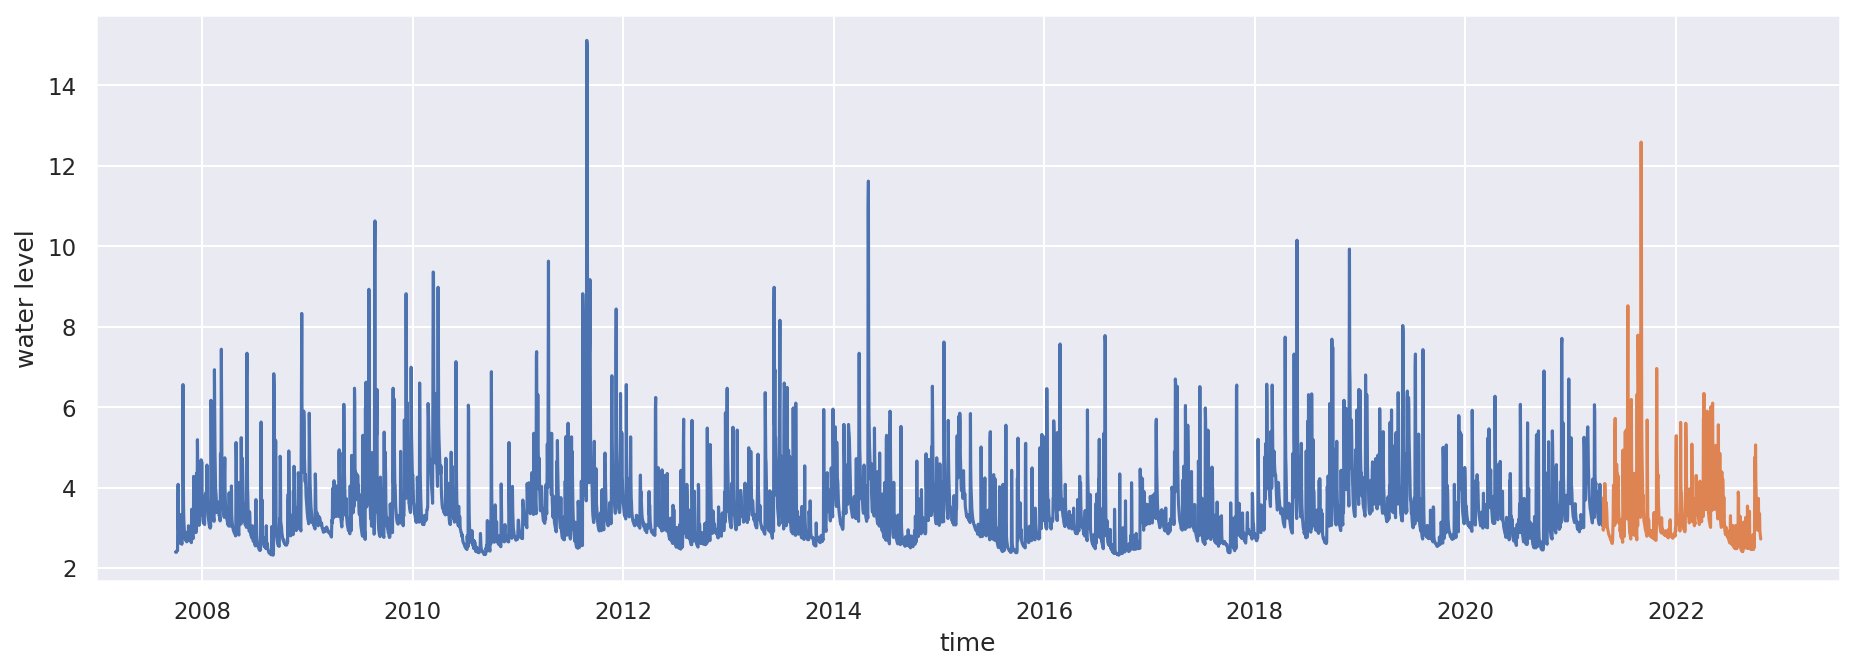

In [13]:
train, test = split_data(df_xgboost, split_date)

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('water level')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [14]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [15]:
X_train, y_train = create_features(train), train['gauge']
X_test, y_test   = create_features(test), test['gauge']

X_train.shape, y_train.shape

((4929, 7), (4929,))

In [16]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
        #stop if 1000 consequent rounds without decrease of error
        verbose=False) 
# Change verbose to True if you want to see it train

[21:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [17]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Water Level')
    plt.plot(base_data.index,base_data, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

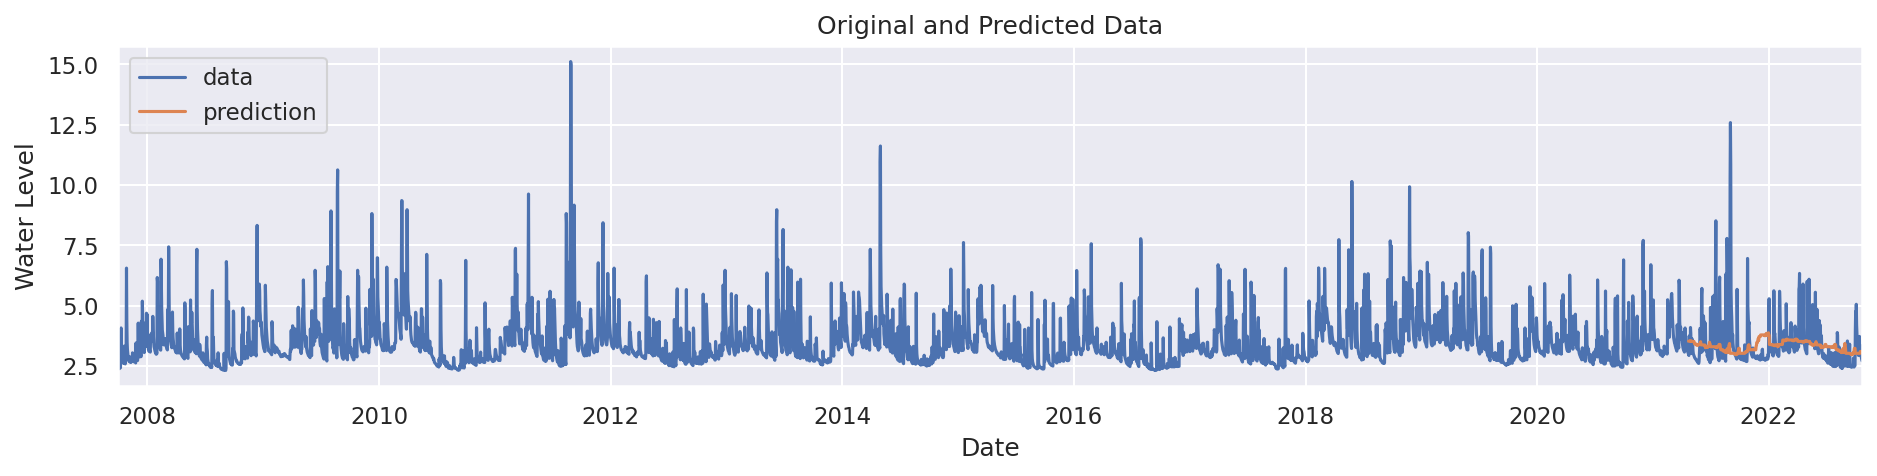

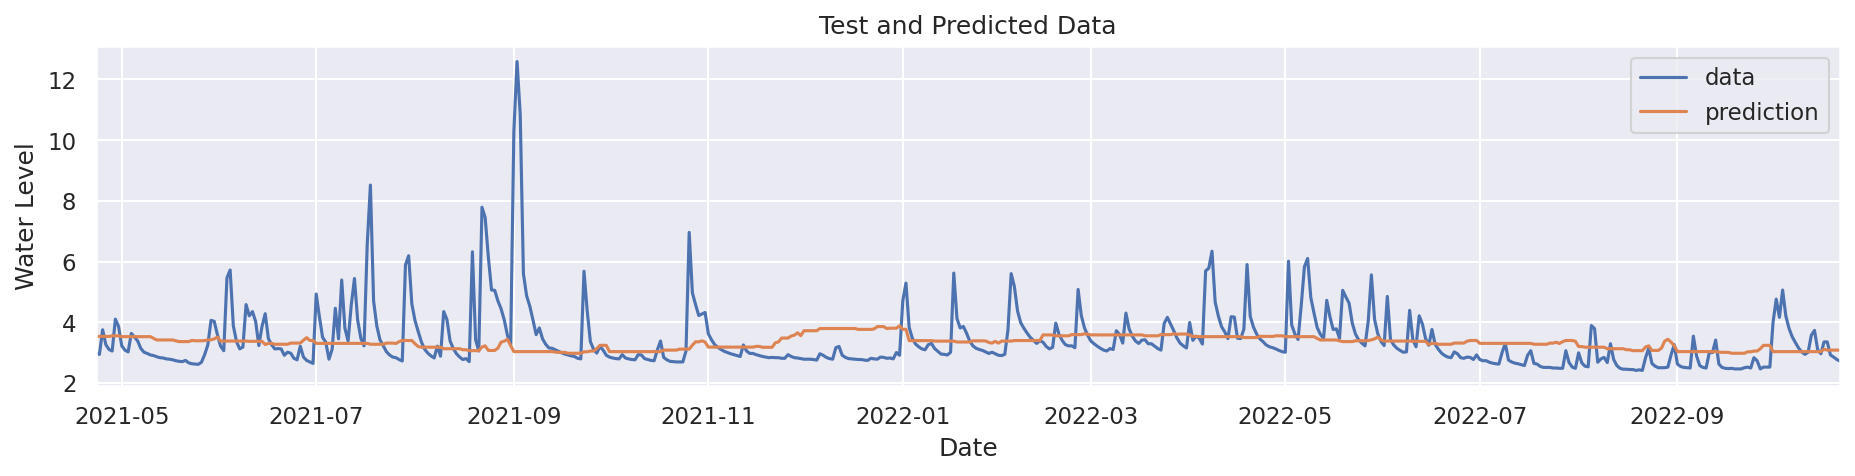

In [18]:
X_test_pred = reg.predict(X_test)
    
plot_performance(df_xgboost, df_xgboost.index[0].date(), df_xgboost.index[-1].date(),
                 'Original and Predicted Data')
plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')
plt.legend()

plt.show()

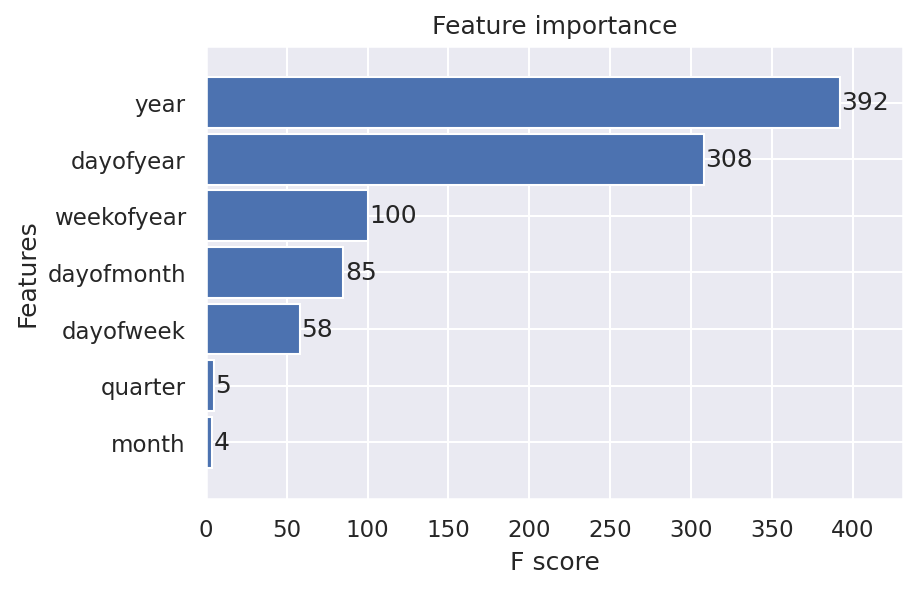

In [19]:
xgb.plot_importance(reg, height=0.9)

In [20]:
#MSE
mean_squared_error(y_test,X_test_pred)

1.1142516077739246

In [21]:
#RMSE

In [22]:
mean_absolute_error(y_test,X_test_pred)

0.6310206409962507

In [23]:
#xgboost multivariate gauge+

In [24]:
from sklearn.metrics import r2_score
R_squared = r2_score(y_test, X_test_pred)
R_squared

-0.03853300803957116

In [25]:
R_squared

-0.03853300803957116

In [26]:
# R2 compares the fit of the chosen model with that of a horizontal straight line (the null hypothesis). If the chosen model fits worse than a horizontal line, 
# then R2 is negative. Note that R2 is not always the square of anything, so it can have a negative value without violating any rules of math. 
#R2 is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line.

In [ ]:
# xgboost with two variables

In [27]:
df3 = df[['date','gauge','discharge','rainfall_ft']]

In [28]:
df3.set_index('date', inplace=True)

In [29]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [30]:
split_date = '2021-4-22'

In [31]:
train, test = split_data(df3, split_date)

In [32]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['gauge_24_hrs_lag'] = df['gauge'].shift(1)
    #df['gauge_24_hrs_mean'] = df['gauge'].rolling(window = 1).mean()
    #df['gauge_24_hrs_std'] = df['gauge'].rolling(window = 1).std()
    #df['gauge_24_hrs_max'] = df['gauge'].rolling(window = 1).max()
    #df['gauge_24_hrs_min'] = df['gauge'].rolling(window = 1).min()
    df['gauge_week_lag'] = df['gauge'].shift(7)
    df['gauge_week_mean'] = df['gauge'].rolling(window = 7).mean()
    df['gauge_week_std'] = df['gauge'].rolling(window = 7).std()
    df['gauge_week_max'] = df['gauge'].rolling(window = 7).max()
    df['gauge_week_min'] = df['gauge'].rolling(window = 7).min()
    df['gauge_year_lag'] = df['gauge'].shift(365)
    df['gauge_year_mean'] = df['gauge'].rolling(window = 365).mean()
    df['gauge_year_std'] = df['gauge'].rolling(window = 365).std()
    df['gauge_year_max'] = df['gauge'].rolling(window = 365).max()
    df['gauge_year_min'] = df['gauge'].rolling(window = 365).min()
    df['discharge_24_hrs_lag'] = df['discharge'].shift(1)
    df['discharge_24_hrs_mean'] = df['discharge'].rolling(window = 1).mean()
    df['discharge_24_hrs_std'] = df['discharge'].rolling(window = 1).std()
    df['discharge_24_hrs_max'] = df['discharge'].rolling(window = 1).max()
    df['discharge_24_hrs_min'] = df['discharge'].rolling(window = 1).min()
    df['discharge_week_lag'] = df['discharge'].shift(7)
    df['discharge_week_mean'] = df['discharge'].rolling(window = 7).mean()
    df['discharge_week_std'] = df['discharge'].rolling(window = 7).std()
    df['discharge_week_max'] = df['discharge'].rolling(window = 7).max()
    df['discharge_week_min'] = df['discharge'].rolling(window = 7).min()
    df['discharge_year_lag'] = df['discharge'].shift(365)
    df['discharge_year_mean'] = df['discharge'].rolling(window = 365).mean()
    df['discharge_year_std'] = df['discharge'].rolling(window = 365).std()
    df['discharge_year_max'] = df['discharge'].rolling(window = 365).max()
    df['discharge_year_min'] = df['discharge'].rolling(window = 365).min()
    df['rainfall_24_hrs_lag'] = df['rainfall_ft'].shift(1)
    df['rainfall_24_hrs_mean'] = df['rainfall_ft'].rolling(window = 1).mean()
    df['rainfall_24_hrs_std'] = df['rainfall_ft'].rolling(window = 1).std()
    df['rainfall_24_hrs_max'] = df['rainfall_ft'].rolling(window = 1).max()
    df['rainfall_24_hrs_min'] = df['rainfall_ft'].rolling(window = 1).min()
    df['rainfall_week_lag'] = df['rainfall_ft'].shift(7)
    df['rainfall_week_mean'] = df['rainfall_ft'].rolling(window = 7).mean()
    df['rainfall_week_std'] = df['rainfall_ft'].rolling(window = 7).std()
    df['rainfall_week_max'] = df['rainfall_ft'].rolling(window = 7).max()
    df['rainfall_week_min'] = df['rainfall_ft'].rolling(window = 7).min()
    df['rainfall_year_lag'] = df['rainfall_ft'].shift(365)
    df['rainfall_year_mean'] = df['rainfall_ft'].rolling(window = 365).mean()
    df['rainfall_year_std'] = df['rainfall_ft'].rolling(window = 365).std()
    df['rainfall_year_max'] = df['rainfall_ft'].rolling(window = 365).max()
    df['rainfall_year_min'] = df['rainfall_ft'].rolling(window = 365).min()


    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear'  , 'gauge_24_hrs_lag' ,'gauge_week_lag','gauge_week_mean','gauge_week_std','gauge_week_max','gauge_week_min','gauge_year_lag','gauge_year_mean','gauge_year_std','gauge_year_max','gauge_year_min',
           'discharge_24_hrs_lag', 'discharge_24_hrs_mean', 'discharge_24_hrs_std', 'discharge_24_hrs_max','discharge_24_hrs_min','discharge_week_lag','discharge_week_mean','discharge_week_std','discharge_week_max','discharge_week_min',
            'discharge_year_lag','discharge_year_mean','discharge_year_std','discharge_year_max','discharge_year_min','rainfall_24_hrs_lag','rainfall_24_hrs_mean','rainfall_24_hrs_std','rainfall_week_max',
            'rainfall_week_min','rainfall_year_lag','rainfall_year_mean','rainfall_year_std','rainfall_year_max','rainfall_year_min']]
    if label:
        y = df[label]
        return X, y
    return X

In [33]:
X_train, y_train = create_features(train), train['gauge']
X_test, y_test   = create_features(test), test['gauge']

X_train.shape, y_train.shape

((4929, 43), (4929,))

In [34]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=False) 

[21:27:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [35]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Water Level')
    plt.plot(base_data.index,base_data, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

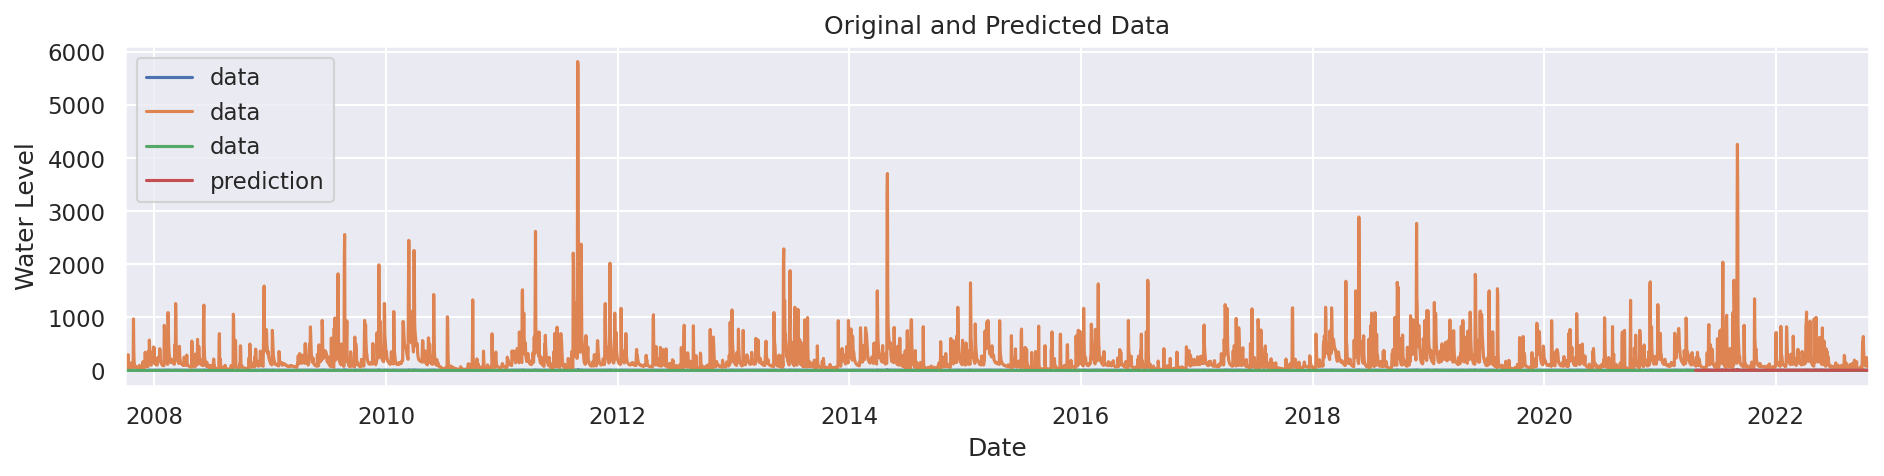

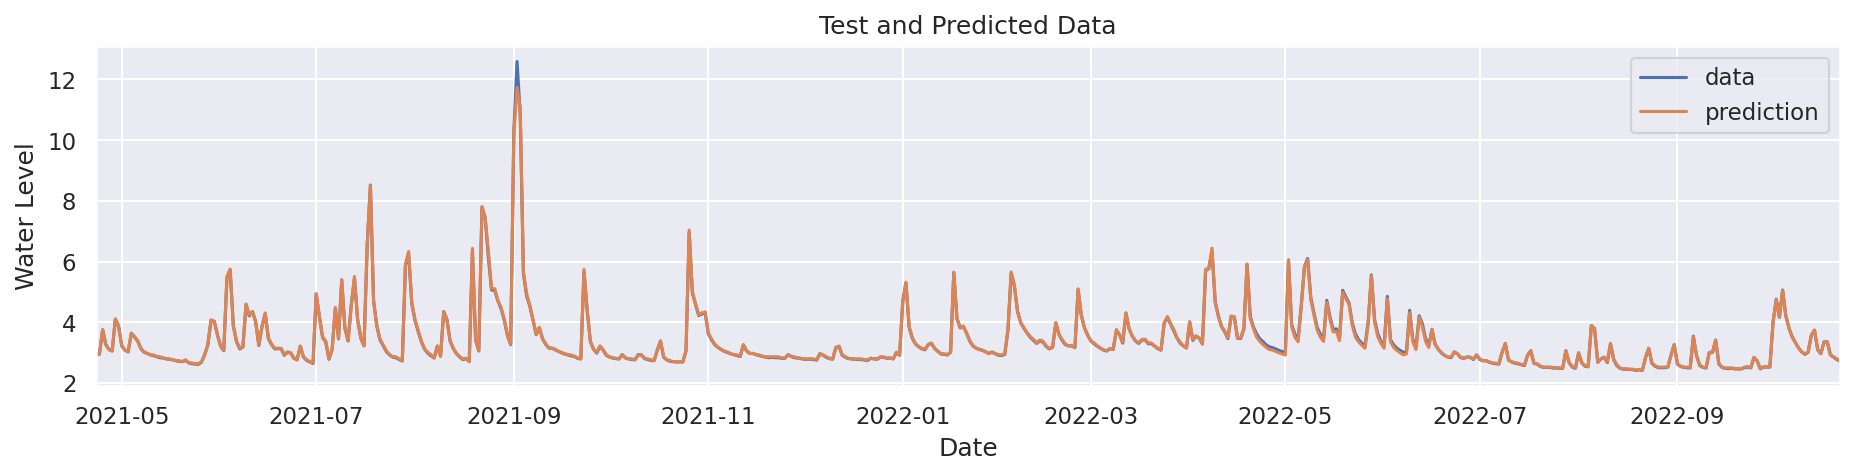

In [36]:
X_test_pred = reg.predict(X_test)
    
plot_performance(df3, df3.index[0].date(), df3.index[-1].date(),
                 'Original and Predicted Data')
plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')
plt.legend()

plt.show()

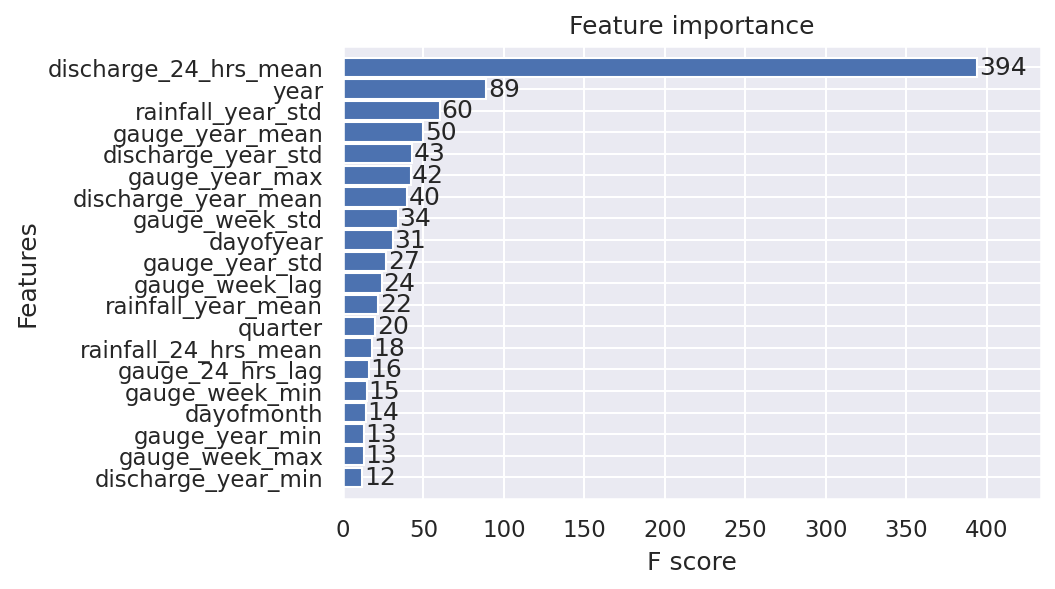

In [37]:
xgb.plot_importance(reg, height=0.9,max_num_features = 20)

In [38]:
mean_squared_error(y_test,X_test_pred)

0.0025008658618693733

In [39]:
mean_absolute_error(y_test,X_test_pred)

0.023394028026692194

In [40]:
R_squared = r2_score(y_test, X_test_pred)

In [41]:
R_squared

0.9976690796512114

In [42]:
# xgboost with two variables 

In [43]:
df3 = df[['date','gauge','discharge','rainfall_ft']]

In [44]:
df3.set_index('date', inplace=True)

In [45]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [46]:
split_date = '2021-4-22'

In [47]:
train, test = split_data(df3, split_date)

In [48]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['gauge_24_hrs_lag'] = df['gauge'].shift(1)
    #df['gauge_24_hrs_mean'] = df['gauge'].rolling(window = 1).mean()
    #df['gauge_24_hrs_std'] = df['gauge'].rolling(window = 1).std()
    #df['gauge_24_hrs_max'] = df['gauge'].rolling(window = 1).max()
    #df['gauge_24_hrs_min'] = df['gauge'].rolling(window = 1).min()
    #df['gauge_week_lag'] = df['gauge'].shift(7)
    #df['gauge_week_mean'] = df['gauge'].rolling(window = 7).mean()
    #df['gauge_week_std'] = df['gauge'].rolling(window = 7).std()
    #df['gauge_week_max'] = df['gauge'].rolling(window = 7).max()
    #df['gauge_week_min'] = df['gauge'].rolling(window = 7).min()
    #df['gauge_year_lag'] = df['gauge'].shift(365)
    #df['gauge_year_mean'] = df['gauge'].rolling(window = 365).mean()
    #df['gauge_year_std'] = df['gauge'].rolling(window = 365).std()
    #df['gauge_year_max'] = df['gauge'].rolling(window = 365).max()
    #df['gauge_year_min'] = df['gauge'].rolling(window = 365).min()
    df['discharge_24_hrs_lag'] = df['discharge'].shift(1)
    df['discharge_24_hrs_mean'] = df['discharge'].rolling(window = 1).mean()
    df['discharge_24_hrs_std'] = df['discharge'].rolling(window = 1).std()
    df['discharge_24_hrs_max'] = df['discharge'].rolling(window = 1).max()
    df['discharge_24_hrs_min'] = df['discharge'].rolling(window = 1).min()
    df['discharge_week_lag'] = df['discharge'].shift(7)
    df['discharge_week_mean'] = df['discharge'].rolling(window = 7).mean()
    df['discharge_week_std'] = df['discharge'].rolling(window = 7).std()
    df['discharge_week_max'] = df['discharge'].rolling(window = 7).max()
    df['discharge_week_min'] = df['discharge'].rolling(window = 7).min()
    df['discharge_year_lag'] = df['discharge'].shift(365)
    df['discharge_year_mean'] = df['discharge'].rolling(window = 365).mean()
    df['discharge_year_std'] = df['discharge'].rolling(window = 365).std()
    df['discharge_year_max'] = df['discharge'].rolling(window = 365).max()
    df['discharge_year_min'] = df['discharge'].rolling(window = 365).min()
    df['rainfall_24_hrs_lag'] = df['rainfall_ft'].shift(1)
    df['rainfall_24_hrs_mean'] = df['rainfall_ft'].rolling(window = 1).mean()
    df['rainfall_24_hrs_std'] = df['rainfall_ft'].rolling(window = 1).std()
    df['rainfall_24_hrs_max'] = df['rainfall_ft'].rolling(window = 1).max()
    df['rainfall_24_hrs_min'] = df['rainfall_ft'].rolling(window = 1).min()
    df['rainfall_week_lag'] = df['rainfall_ft'].shift(7)
    df['rainfall_week_mean'] = df['rainfall_ft'].rolling(window = 7).mean()
    df['rainfall_week_std'] = df['rainfall_ft'].rolling(window = 7).std()
    df['rainfall_week_max'] = df['rainfall_ft'].rolling(window = 7).max()
    df['rainfall_week_min'] = df['rainfall_ft'].rolling(window = 7).min()
    df['rainfall_year_lag'] = df['rainfall_ft'].shift(365)
    df['rainfall_year_mean'] = df['rainfall_ft'].rolling(window = 365).mean()
    df['rainfall_year_std'] = df['rainfall_ft'].rolling(window = 365).std()
    df['rainfall_year_max'] = df['rainfall_ft'].rolling(window = 365).max()
    df['rainfall_year_min'] = df['rainfall_ft'].rolling(window = 365).min()


    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear'  , 'gauge_24_hrs_lag','discharge_24_hrs_lag', 'discharge_24_hrs_mean', 'discharge_24_hrs_std', 'discharge_24_hrs_max','discharge_24_hrs_min','discharge_week_lag','discharge_week_mean','discharge_week_std','discharge_week_max','discharge_week_min',
            'discharge_year_lag','discharge_year_mean','discharge_year_std','discharge_year_max','discharge_year_min','rainfall_24_hrs_lag','rainfall_24_hrs_mean','rainfall_24_hrs_std','rainfall_week_max',
            'rainfall_week_min','rainfall_year_lag','rainfall_year_mean','rainfall_year_std','rainfall_year_max','rainfall_year_min']]
    if label:
        y = df[label]
        return X, y
    return X

In [49]:
X_train, y_train = create_features(train), train['gauge']
X_test, y_test   = create_features(test), test['gauge']

X_train.shape, y_train.shape

((4929, 33), (4929,))

In [50]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=False) 

[21:27:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [51]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Water Level')
    plt.plot(base_data.index,base_data, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

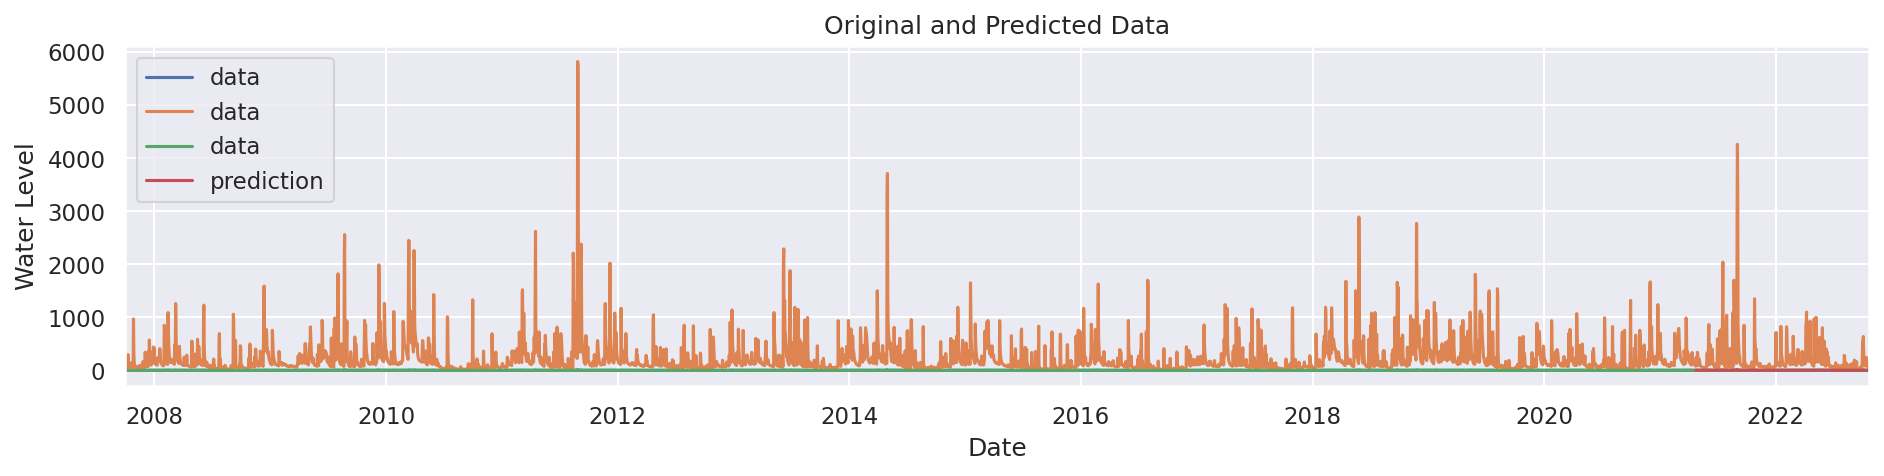

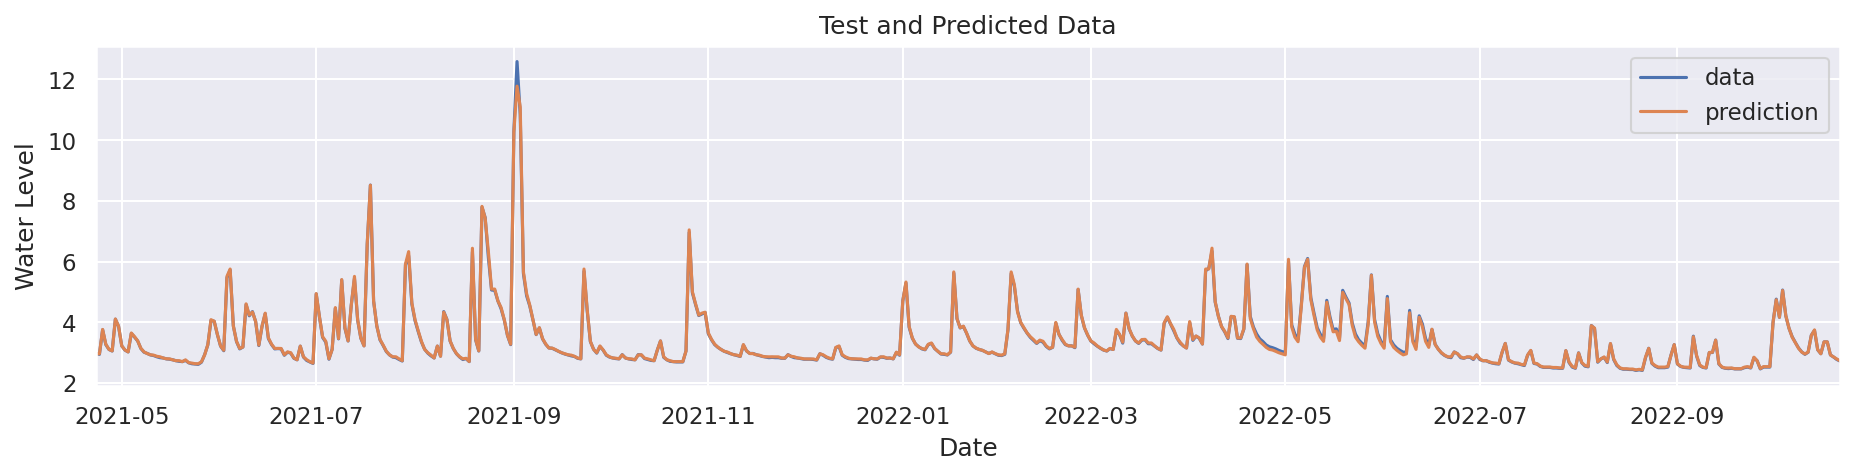

In [52]:
X_test_pred = reg.predict(X_test)
    
plot_performance(df3, df3.index[0].date(), df3.index[-1].date(),
                 'Original and Predicted Data')
plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')
plt.legend()

plt.show()

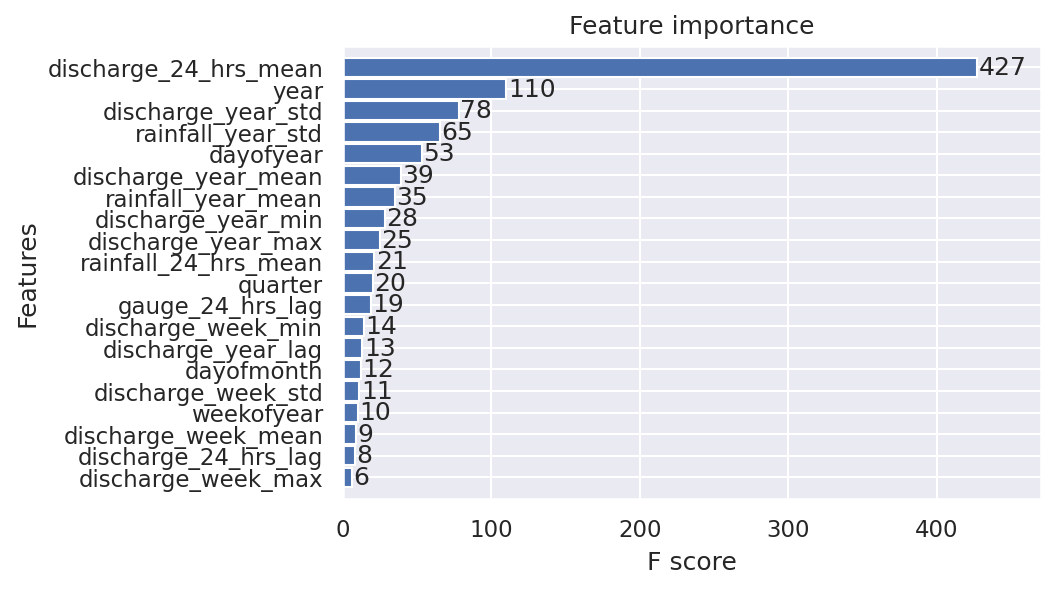

In [53]:
xgb.plot_importance(reg, height=0.9,max_num_features = 20)

In [54]:
from sklearn.metrics import r2_score
R_squared = r2_score(y_test, X_test_pred)
R_squared

0.9978520602385562